### Import Libraries

In [1]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### Customization 

In [2]:
my_normal_report = "0603 Normal_Network_Report.csv"
my_disrupted_report = "0603 Disrupted_Network_Report.csv"
my_network_plot="0603 Supply_chain_network.png"
my_disrupted_plot="0603 Disrupted_Supply_chain_network.png"


# Add supply chain nodes
nodes = ['Factory', 'Warehouse1', 'Warehouse2', 'Retailer1', 'Retailer2']

# Add edges with cost and time attributes
edges = [
    ('Factory', 'Warehouse1', {'cost': 80, 'time': 2}),
    ('Factory', 'Warehouse2', {'cost': 75, 'time': 3}),
    ('Warehouse1', 'Retailer1', {'cost': 55, 'time': 1}),
    ('Warehouse2', 'Retailer2', {'cost': 45, 'time': 3}),
    ('Warehouse2', 'Retailer1', {'cost': 65, 'time': 3}),
    ('Warehouse1', 'Retailer2', {'cost': 55, 'time': 2})
]

my_source='Factory'
my_target='Retailer2'

# Under disruption scenario
disruption_source='Factory'
disruption_target='Warehouse2'

### Create the model 

In [3]:
# Creating the Supply Chain Network 
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)


### Analyse shortest path and centrality

In [4]:
# Analyze Shortest Paths and Centrality (BEFORE disruption)
print("=== NORMAL NETWORK ANALYSIS ===")
lowest_cost_path = nx.shortest_path(G, source=my_source, target=my_target, weight='cost')
lowest_time_path = nx.shortest_path(G, source=my_source, target=my_target, weight='time')
path_cost = nx.path_weight(G, lowest_cost_path, weight='cost')
path_time = nx.path_weight(G, lowest_time_path, weight='time')

print(f"Shortest path by cost: {lowest_cost_path}")
print(f"Total cost: {path_cost}")
print(f"Shortest path by time: {lowest_time_path}")
print(f"Total time: {path_time}")

# Centrality calculation for original network
centrality_normal = nx.betweenness_centrality(G, weight='time')
print(f"Centrality scores (normal network): {centrality_normal}")


=== NORMAL NETWORK ANALYSIS ===
Shortest path by cost: ['Factory', 'Warehouse2', 'Retailer2']
Total cost: 120
Shortest path by time: ['Factory', 'Warehouse1', 'Retailer2']
Total time: 4
Centrality scores (normal network): {'Factory': 0.0, 'Warehouse1': 0.16666666666666666, 'Warehouse2': 0.0, 'Retailer1': 0.0, 'Retailer2': 0.0}


### Simulate Disruption

In [5]:
def simulate_disruption(graph, disrupted_edge):
    G_copy = graph.copy()
    result = {}
    if G_copy.has_edge(*disrupted_edge):
        print(f"\nRemoving edge: {disrupted_edge}")
        G_copy.remove_edge(*disrupted_edge)
        try:
            new_path = nx.shortest_path(G_copy, source=my_source, target=my_target, weight='cost')
            new_cost = nx.path_weight(G_copy, new_path, weight='cost')
            result['New Path'] = new_path
            result['New Cost'] = new_cost
            print(f"New path after disruption: {new_path}")
            print(f"New cost after disruption: {new_cost}")
        except nx.NetworkXNoPath:
            result['New Path'] = 'No path available'
            result['New Cost'] = float('inf')
            print("No path available after disruption")
    else:
        print(f"Edge {disrupted_edge} does not exist in the graph")
        result['New Path'] = 'Edge does not exist'
        result['New Cost'] = 'N/A'
    
    return result, G_copy

print("\n=== DISRUPTION ANALYSIS ===")
disruption_result, G_disrupted = simulate_disruption(G, (disruption_source, disruption_target))

# Centrality calculation for disrupted network
centrality_disrupted = nx.betweenness_centrality(G_disrupted, weight='time')
print(f"Centrality scores (disrupted network): {centrality_disrupted}")

# Compare centrality changes
print("\n=== CENTRALITY COMPARISON ===")
for node in nodes:
    if node in centrality_normal and node in centrality_disrupted:
        change = centrality_disrupted[node] - centrality_normal[node]
        print(f"{node}: Normal={centrality_normal[node]:.3f}, Disrupted={centrality_disrupted[node]:.3f}, Change={change:.3f}")



=== DISRUPTION ANALYSIS ===

Removing edge: ('Factory', 'Warehouse2')
New path after disruption: ['Factory', 'Warehouse1', 'Retailer2']
New cost after disruption: 135
Centrality scores (disrupted network): {'Factory': 0.0, 'Warehouse1': 0.16666666666666666, 'Warehouse2': 0.0, 'Retailer1': 0.0, 'Retailer2': 0.0}

=== CENTRALITY COMPARISON ===
Factory: Normal=0.000, Disrupted=0.000, Change=0.000
Warehouse1: Normal=0.167, Disrupted=0.167, Change=0.000
Warehouse2: Normal=0.000, Disrupted=0.000, Change=0.000
Retailer1: Normal=0.000, Disrupted=0.000, Change=0.000
Retailer2: Normal=0.000, Disrupted=0.000, Change=0.000


### Visualisation - Plotting

In [6]:
# Visualization - Normal Network
def visualize_normal_network(graph, filename="supply_chain_network.png"):
    pos = nx.spring_layout(graph, seed=42)  # Fixed seed for consistent layout
    plt.figure(figsize=(10, 6))
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray')
    edge_labels = {(u, v): f"${d['cost']}, {d['time']}h" for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Supply Chain Network (Cost, Time)")
    plt.savefig(filename)
    plt.show()
    plt.close()

# Visualization - Disrupted Network
def visualize_disrupted_network(original_graph, disrupted_graph, disrupted_edge, new_path=None, filename="disrupted_network.png"):
    pos = nx.spring_layout(original_graph, seed=42)  # Same layout as original
    plt.figure(figsize=(10, 6))

    # Draw all remaining nodes and edges
    nx.draw(disrupted_graph, pos, with_labels=True, node_color='lightcoral', node_size=2000, edge_color='gray')

    # Highlight the new path in green (if any)
    if new_path and new_path != 'No path available' and new_path != 'Edge does not exist':
        path_edges = list(zip(new_path[:-1], new_path[1:]))
        nx.draw_networkx_edges(disrupted_graph, pos, edgelist=path_edges, edge_color='green', width=3)

    # Draw edge labels with cost and time for remaining edges
    edge_labels = {(u, v): f"${d['cost']}, {d['time']}h" for u, v, d in disrupted_graph.edges(data=True)}
    nx.draw_networkx_edge_labels(disrupted_graph, pos, edge_labels=edge_labels)

    plt.title(f"Disrupted Network (Edge Removed: {disrupted_edge})")
    plt.savefig(filename)
    plt.show()
    plt.close()



### Visualization


=== GENERATING VISUALIZATIONS ===


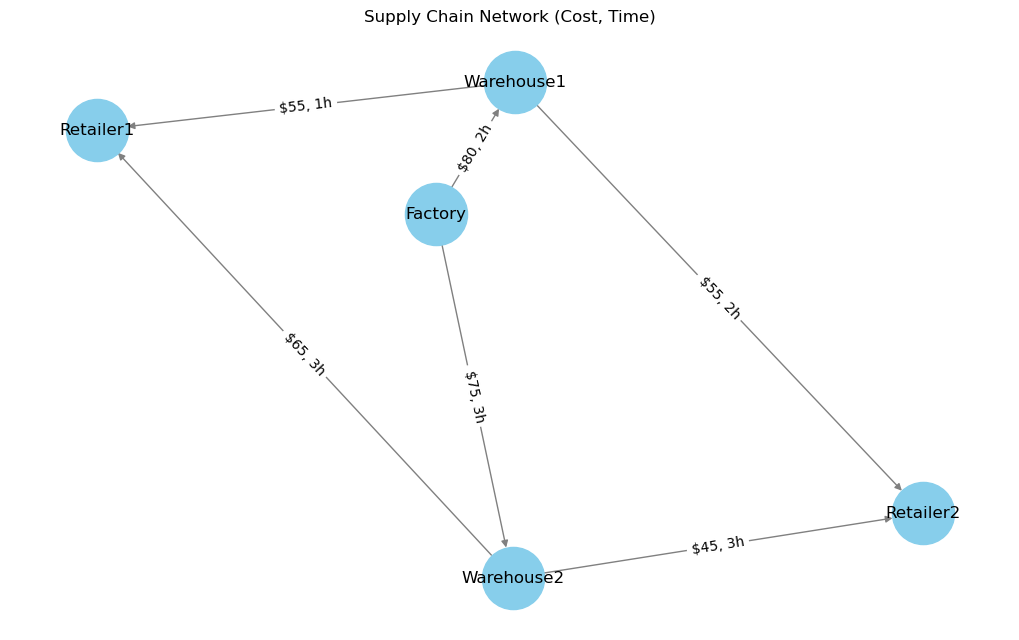

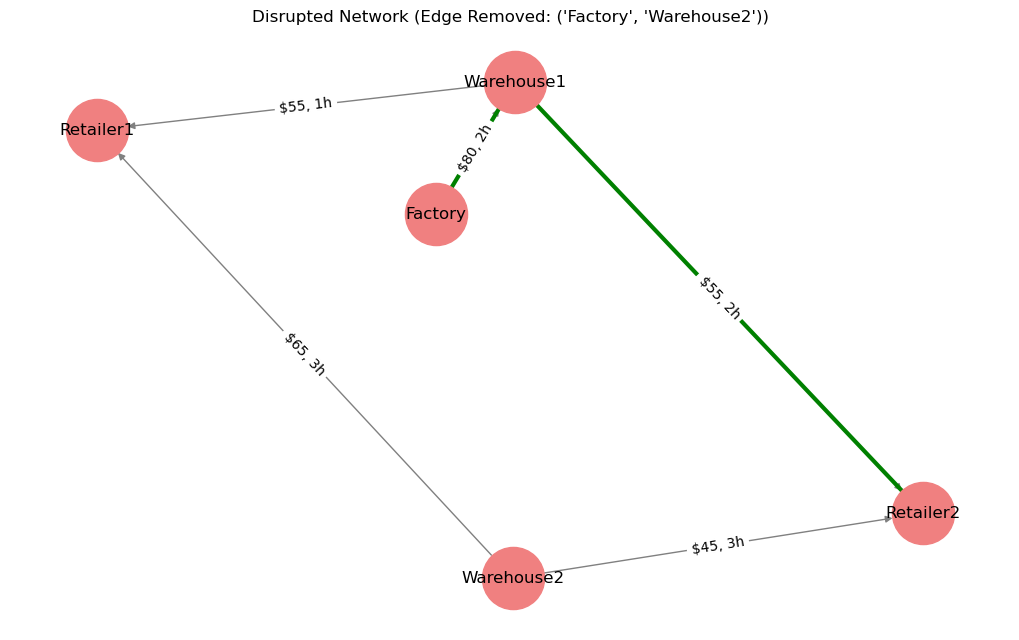

In [7]:
# Generate visualizations
print("\n=== GENERATING VISUALIZATIONS ===")
visualize_normal_network(G, my_network_plot)
visualize_disrupted_network(G, G_disrupted, (disruption_source, disruption_target), 
                           disruption_result['New Path'], my_disrupted_plot)


### Compute network results

In [8]:
# Normal network results
normal_output = {
    "Metric": ["Shortest Path by Cost", "Total Cost", "Shortest Path by Time", "Total Time"] + 
              [f"Centrality_{node}" for node in nodes],
    "Value": [str(lowest_cost_path), path_cost, str(lowest_time_path), path_time] + 
             [centrality_normal[node] for node in nodes]
}

# Disrupted network results
disrupted_output = {
    "Metric": ["Disrupted Edge", "New Path", "New Cost"] + 
              [f"Centrality_{node}" for node in nodes if node in centrality_disrupted],
    "Value": [str((disruption_source, disruption_target)), 
              str(disruption_result['New Path']), 
              disruption_result['New Cost']] + 
             [centrality_disrupted[node] for node in nodes if node in centrality_disrupted]
}


### Data display and export to file

In [9]:
# Create DataFrames and save to CSV
df_normal = pd.DataFrame(normal_output)
df_disrupted = pd.DataFrame(disrupted_output)

df_normal.to_csv(my_normal_report, index=False)
df_disrupted.to_csv(my_disrupted_report, index=False)

print("Normal Network Report:")
print(df_normal)
print("\nDisrupted Network Report:")
print(df_disrupted)

# Summary Analysis
print("\n=== SUMMARY ANALYSIS ===")
print(f"Original path cost: {path_cost}")
if disruption_result['New Cost'] != float('inf') and disruption_result['New Cost'] != 'N/A':
    cost_increase = disruption_result['New Cost'] - path_cost
    print(f"New path cost after disruption: {disruption_result['New Cost']}")
    print(f"Cost increase due to disruption: {cost_increase}")
    print(f"Percentage increase: {(cost_increase/path_cost)*100:.1f}%")
else:
    print("Network becomes disconnected after disruption")

# Most critical nodes (highest centrality)
most_critical_normal = max(centrality_normal, key=centrality_normal.get)
most_critical_disrupted = max(centrality_disrupted, key=centrality_disrupted.get)
print(f"Most critical node in normal network: {most_critical_normal} (centrality: {centrality_normal[most_critical_normal]:.3f})")
print(f"Most critical node in disrupted network: {most_critical_disrupted} (centrality: {centrality_disrupted[most_critical_disrupted]:.3f})")

Normal Network Report:
                  Metric                                   Value
0  Shortest Path by Cost  ['Factory', 'Warehouse2', 'Retailer2']
1             Total Cost                                     120
2  Shortest Path by Time  ['Factory', 'Warehouse1', 'Retailer2']
3             Total Time                                       4
4     Centrality_Factory                                     0.0
5  Centrality_Warehouse1                                0.166667
6  Centrality_Warehouse2                                     0.0
7   Centrality_Retailer1                                     0.0
8   Centrality_Retailer2                                     0.0

Disrupted Network Report:
                  Metric                                   Value
0         Disrupted Edge               ('Factory', 'Warehouse2')
1               New Path  ['Factory', 'Warehouse1', 'Retailer2']
2               New Cost                                     135
3     Centrality_Factory                